In [18]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
from matplotlib.colors import LinearSegmentedColormap
import os
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
buoy = sio.loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')

In [3]:
buoy = buoy['ecbuoy']

In [4]:
buoy_dtype = buoy.dtype
buoydata = {n: buoy[n][0, 0] for n in buoy_dtype.names}

In [5]:
buoydata.keys()

dict_keys(['comment', 'lat', 'lon', 'tz', 'mtime', 'temp', 'specc', 'turb', 'o2', 'pH', 'salR', 'O2sat', 'vel', 'airtemp', 'cwind', 'wspd', 'wdir', 'wu', 'wv', 'patm', 'depth', 'dailyturb'])

In [6]:
temps = buoydata['temp'][:,0]
sals = buoydata['salR'][:,0]
mtimes = buoydata['mtime'][:,0]

In [7]:
mtimes.shape

(90613,)

In [8]:
base = datetime.datetime(2000, 1, 1)
py_buoy_times = np.array([base for i in range(mtimes.shape[0])])
print(py_buoy_times.shape)
for n in range(mtimes.shape[0]):
    py_buoy_times[n] = ((datetime.datetime.fromordinal(int(mtimes[n])))
                       + datetime.timedelta(days=mtimes[n]%1)
                       - datetime.timedelta(days = 366))

(90613,)


In [9]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [10]:
buoydata['lon'][0][0]

-123.0385659

In [11]:
geo_tools.find_closest_model_point(buoydata['lon'][0][0], buoydata['lat'][0][0], 
                                   X, Y, land_mask = bathy.mask)

(415, 337)

In [12]:
start_date = datetime.datetime(2013, 1, 1)
end_date = datetime.datetime(2018,11,15)

temps = temps[(py_buoy_times > start_date) & (py_buoy_times < end_date)]
sals = sals[(py_buoy_times > start_date) & (py_buoy_times < end_date)]
py_buoy_times = py_buoy_times[(py_buoy_times > start_date) & (py_buoy_times < end_date)]

In [13]:
print(temps.shape)

(49259,)


In [15]:
HINDCAST_PATH = '/results/SalishSea/hindcast.201905/'

In [22]:
sal_model = np.array([])
t_model = np.array([])

depth=1
Yind = 415
Xind = 337
for n in range(temps.shape[0]):
    date = py_buoy_times[n]
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
    after = before + datetime.timedelta(hours=1)
    sub_dir2 = after.strftime('%d%b%y').lower()
    datestr2 = after.strftime('%Y%m%d')
    fname2 = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr2, datestr2)
    nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
    delta = (date.minute) / 60
    t_val = (delta*(nuts.variables['votemper'][before.hour, depth, Yind, Xind] ) + 
               (1- delta)*(nuts2.variables['votemper'][after.hour, depth, Yind, Xind] ))
    t_model = np.append(t_model, t_val)
    
    s_val = (delta*(nuts.variables['vosaline'][before.hour, depth, Yind, Xind] ) + 
               (1- delta)*(nuts2.variables['vosaline'][after.hour, depth, Yind, Xind] ))
    sal_model = np.append(sal_model, s_val)

/home/vdo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


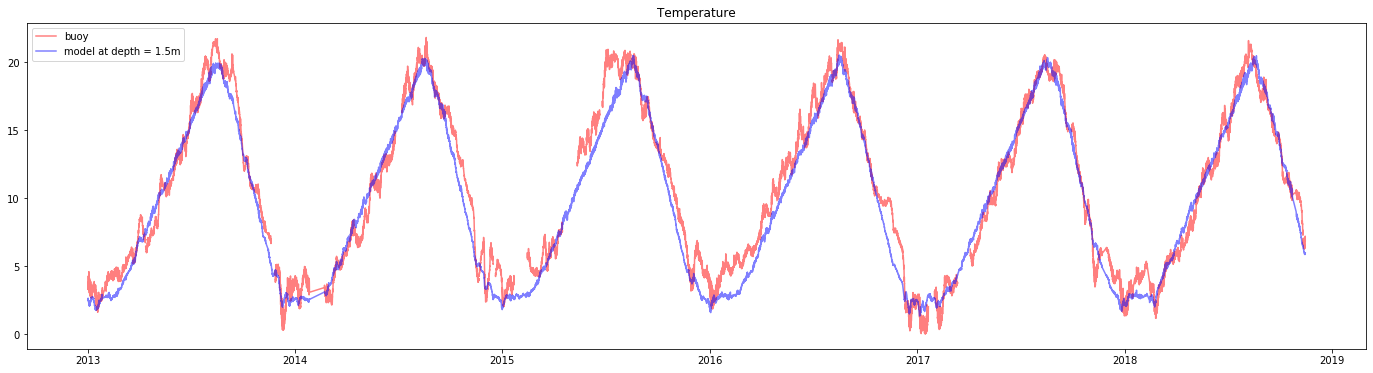

In [23]:
fig, ax = plt.subplots(figsize = (24,6))
ax.plot(py_buoy_times, temps, 'r-', alpha = 0.5, label = 'buoy')
ax.plot(py_buoy_times, t_model, 'b-', alpha = 0.5, label = 'model at depth = 1.5m')
ax.legend()
ax.set_title('Temperature');

In [24]:
temps = np.ma.masked_invalid(temps)
t_model = np.ma.masked_array(t_model, mask = temps.mask)
print(np.ma.count(temps))

46397


In [25]:
from matplotlib.colors import LogNorm

In [26]:
temps = temps.compressed()
t_model = t_model.compressed()

bias =  -0.5324958732386325
RMSE = 1.2845267701094691
Willmott = 0.9879538428092625


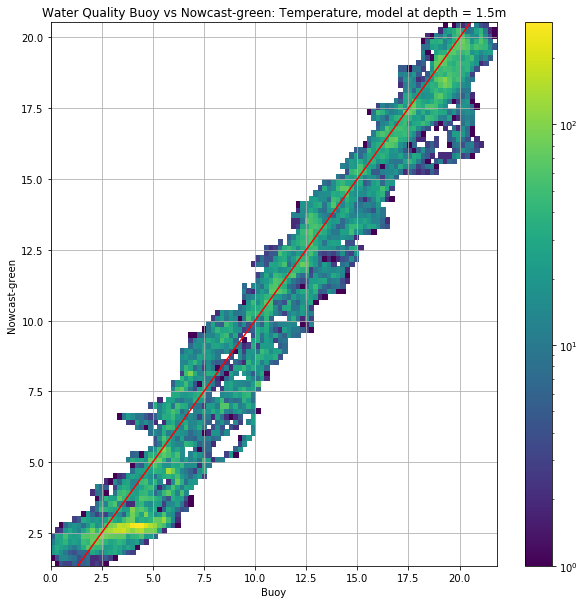

In [27]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(temps, t_model,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Temperature, model at depth = 1.5m')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(temps) + np.mean(t_model)))
print('RMSE = ' + str(np.sqrt(np.sum((t_model - temps)**2) /
                              len(t_model))))
xbar = np.mean(temps)
print('Willmott = ' + str(1-(np.sum((t_model - temps)**2)  / 
                             np.sum((np.abs(t_model - xbar) 
                                     + np.abs(temps - xbar))**2))))

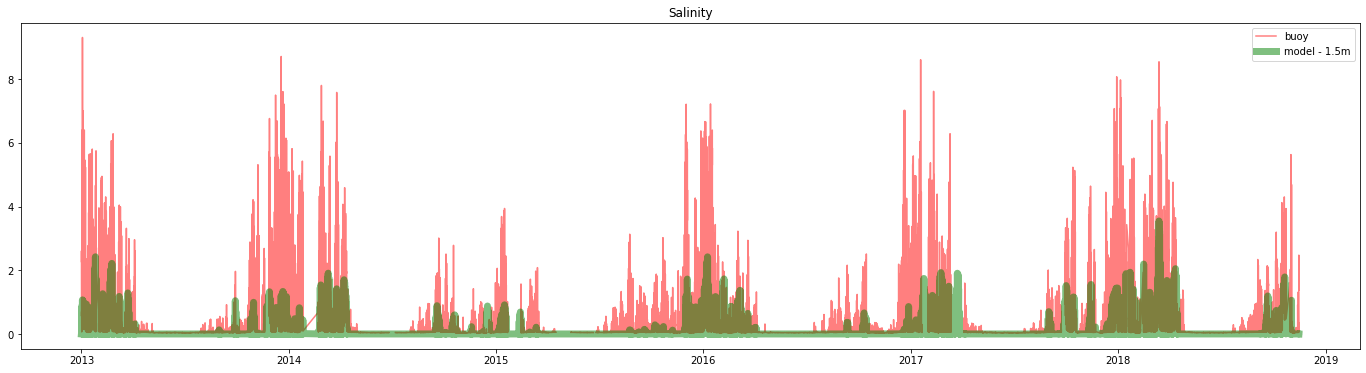

In [28]:
fig, ax = plt.subplots(figsize = (24,6))
ax.plot(py_buoy_times, sals, 'r-', alpha = 0.5, label = 'buoy')
ax.plot(py_buoy_times, sal_model, 'g-', alpha = 0.5, linewidth = 7, label = 'model - 1.5m')
ax.legend()
ax.set_title('Salinity');

In [29]:
sals = np.ma.masked_invalid(sals)
sal_model = np.ma.masked_array(sal_model, mask = sals.mask)
sals = sals.compressed()
sal_model = sal_model.compressed()

In [30]:
len(sals)

46396

bias =  -0.29644363893673537
RMSE = 0.7931721676704974
Willmott = 0.42439473884712553


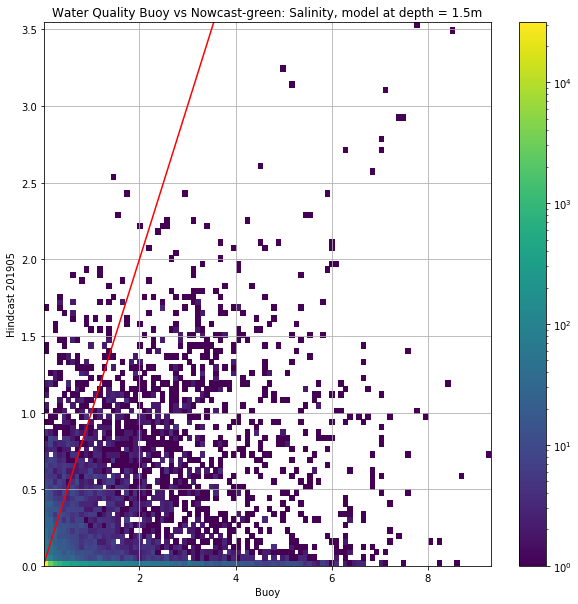

In [31]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(sals, sal_model,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Salinity, model at depth = 1.5m')
ax.set_xlabel('Buoy')
ax.set_ylabel('Hindcast 201905');
print('bias =  ' + str(-np.mean(sals) + np.mean(sal_model)))
print('RMSE = ' + str(np.sqrt(np.sum((sal_model - sals)**2) /
                              len(sal_model))))
xbar = np.mean(sals)
print('Willmott = ' + str(1-(np.sum((sal_model - sals)**2)  / 
                             np.sum((np.abs(sal_model - xbar) 
                                     + np.abs(sals - xbar))**2))))